# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [42]:
import pandas as pd

pd.set_option('display.float_format', '{:,.2f}'.format)

data = pd.read_csv('/datasets/data.csv')

data.head(10) #вывод на экран первых 10 строк датасета


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,-926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"-2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,-152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"-6,929.87",35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"-2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


In [43]:
#информация о данных в таблице
data.describe() 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","19,351.00"
mean,0.54,"63,046.50",43.29,0.82,0.97,0.08,"167,422.30"
std,1.38,"140,827.31",12.57,0.55,1.42,0.27,"102,971.57"
min,-1.00,"-18,388.95",0.00,0.00,0.00,0.00,"20,667.26"
25%,0.00,"-2,747.42",33.00,1.00,0.00,0.00,"103,053.15"
50%,0.00,"-1,203.37",42.00,1.00,0.00,0.00,"145,017.94"
75%,1.00,-291.10,53.00,1.00,1.00,0.00,"203,435.07"
max,20.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03"


In [44]:
#информация о пропущенных значениях 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод:** Видно, что в данных есть проблемы.
1. Пропуски в столбцах 'days_employed' и 'total_income'. Т.к пропусков одинаковое количество, то нужно проверить гипотезу, что пропуски есть одновременно в обоих столбцах.
2. Отрицательные значения в столбце 'days_employed'. Возможно отрицательные значения трудового стажа связаны с выходом человека на пенсию. 
3. Тип данных в столбцах 'days_employed'и 'total_income'нужно поменять на int64
4. Различное написание(строчные и прописные буквы) в столбце 'education'.
5. Странные значения столбца 'children'. -1 ребёнка быть не может.
6. Нулевые значения в 'dob_years'. Возраст не может равняться 0. Возможно значения пропущены. 

## Шаг 2. Предобработка данных

### Обработка пропусков

In [45]:
#В столбцах 'days_employed' и 'total_income' одинаковое количество пропусков. Проверим связаны ли отсутсвия данных по трудовому стажу и по доходам.

data[(data['days_employed'].isnull() == True) & (data['total_income'].isnull() == True)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Предположение подтвердилось, пропуски в обоих столбцах одновременно. Нужно проверить относятся ли значения с пропусками к одной группе(например люди одной статуса(например: госслужащий). Если да, то можно будет заполнить пропуски средними значениями по этой группе.

In [46]:
#Проверим распределение пропусков по профессиям

data[(data['days_employed'].isnull() == True) & (data['total_income'].isnull() == True)]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

**Вывод:** Данные относятся к разным группам, значит для заполнения пропусков нужно будет использовать средние значения для каждой группы в отдельности.

In [47]:
#Проверим, что отрицательные значения в days_employed как-то связаны с выходом человека на пенсию. 
#Для этого найдём строки 'days_employed' с значениями больше и меньше нуля и соотнесем их с количеством строк, 
#со значением 'income_type' == 'пенсионер'

print('Трудовой стаж > 0:', data[data['days_employed'] > 0].shape[0])
print('Трудовой стаж < 0:', data[data['days_employed'] < 0].shape[0])
print('Пенсионеры с трудовым стажем > 0:', data[(data['days_employed'] > 0) & (data['income_type'] == 'пенсионер')].shape[0])
print('Пенсионеры с трудовым стажем > 0:', data[(data['days_employed'] < 0) & (data['income_type'] == 'пенсионер')].shape[0])

Трудовой стаж > 0: 3445
Трудовой стаж < 0: 15906
Пенсионеры с трудовым стажем > 0: 3443
Пенсионеры с трудовым стажем > 0: 0


**Вывод:** Пограничным значением в этих данных считается выход человека на пенсию. У всех работающих сейчас значения в 'days_employed' отрицательные. У пенсионеров положительные. Ещё два значения относятся к какой-то другой группе.

In [48]:
#Сгруппируем данные по типу занятости.Посчитам количесто строк, средние и значения больше 0 в столбце 'days_employed'

data_grouped = data.groupby('income_type').agg({'days_employed':['count', 'mean', lambda x: sum(x>0)]})

dict_to_rename = dict(zip(data_grouped.columns.levels[1], ['Общее количество строк', 'Среднее', 'Кол-во значений > 0']))

data_grouped = data_grouped.rename(columns=dict_to_rename, level=1)
data_grouped

days_employed                               
                Общее количество строк    Среднее Кол-во значений > 0
income_type                                                          
безработный                          2 366,413.65                2.00
в декрете                            1  -3,296.76                0.00
госслужащий                       1312  -3,399.90                0.00
компаньон                         4577  -2,111.52                0.00
пенсионер                         3443 365,003.49            3,443.00
предприниматель                      1    -520.85                0.00
сотрудник                        10014  -2,326.50                0.00
студент                              1    -578.75                0.00

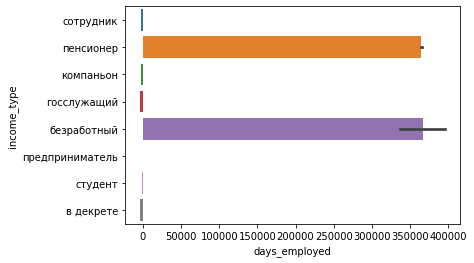

In [49]:
import seaborn
seaborn.barplot(x='days_employed', y='income_type' ,data=data)


**Вывод:** Видно, что кроме пенсионеров отрицательные значения days_employed так же есть у безработных. Для всех остальных категорий значения положительные.

In [50]:
#Чтобы избавиться от отрицательных значений возьмём значения столбцов по модулю 
data[['total_income', 'days_employed']] = data[['total_income', 'days_employed']].abs()

data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"6,929.87",35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


In [51]:
#заполняем пропуски в столбцах 'days_employed' и 'income_type' средними значениями
groups = data.groupby(['education', 'income_type'])['days_employed'].transform('median')
groups1 = data.groupby(['education', 'income_type'])['total_income'].transform('median')
print(groups)

data['days_employed'] = data['days_employed'].fillna(groups)
data['total_income'] = data['total_income'].fillna(groups)

0         1,548.65
1         1,607.38
2         1,730.67
3         1,607.38
4       365,232.44
           ...    
21520     1,645.33
21521   365,232.44
21522     1,607.38
21523     1,607.38
21524     1,607.38
Name: days_employed, Length: 21525, dtype: float64


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [53]:
#Приводим к единому виду значения в столбце 'education'
data['education'] = data['education'].str.lower()
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"5,623.42",33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,152.78,50,среднее,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"6,929.87",35,высшее,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


In [54]:
#Посчитаем количество строк в которых есть значение 'children' -1
print('Строки со значением children -1:', data[data['children'] == -1].count()[0])

Строки со значением children -1: 47


In [55]:
#Заменим количество детей с -1 на 0
data['children'] = data['children'].replace(-1, 0)

In [56]:
#Посчитаем количество строк со нулевым значением 'dob_years'
print("Количество строк с 'dob_years' 0 -", data[data['dob_years'] == 0].count()[0])
#Сравним количество строк с нулевым значением 'dob_years' и количество сторк со значением 'dob_years' < 18
print("Количество строк с 'dob_years' < 18 -", data[data['dob_years'] < 18].count()[0])

Количество строк с 'dob_years' 0 - 101
Количество строк с 'dob_years' < 18 - 101


**Вывод:** Возможно значения 0 в 'dob_years' обусловлено тем, что при заполнение таблицы, так отмечали всех несовершеннолетних. 
Тк кредиты у нас выдают только c 18 лет.

In [57]:
#Заменим нулевые значения средними из группы до 18 лет
data['dob_years'] = data.groupby('income_type')['dob_years'].transform(lambda x: x.replace(0, int(x.mean())))

In [58]:
#Проверим? остались ли строки с 0 значением в 'dob_years'
print("Количество строк с 'dob_years' 0 -", data[data['dob_years'] == 0].count()[0])

Количество строк с 'dob_years' 0 - 0


### Замена типа данных

In [59]:
#Изменим тип данных в столбцах 'days_employed' и 'total_income' на целочисленный

In [60]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод** Данные в 'days_employed' и 'total_income' приведены к целочисленным. т.к в таком виде они легче воспринимаются при просмотре и дробная часть этих данных не влияет на общую картину принятия решиний по кредиту. 

### Обработка дубликатов

In [61]:
#Посчитаем общее количество дубликатов в датафрейме
data.duplicated().sum()

54

In [62]:
#Посмотрим на них
data[data.duplicated(keep=False)].sort_values('dob_years', ascending = False).head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5865,0,365232,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,365232,операции со своей недвижимостью
9528,0,365232,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,365232,операции со своей недвижимостью
3609,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,жилье
20702,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,дополнительное образование
12389,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,дополнительное образование
18428,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,жилье
8178,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,автомобиль
13639,0,365232,64,среднее,1,женат / замужем,0,F,пенсионер,0,365232,автомобиль
10864,0,365232,62,среднее,1,женат / замужем,0,F,пенсионер,0,365232,ремонт жилью
10994,0,365232,62,среднее,1,женат / замужем,0,F,пенсионер,0,365232,ремонт жилью


**Вывод:** Возможно при вводе или импорте эти строки были продублированны по несколько раз, т.к. данные в них полностью совпадают.

In [63]:
#убираем добликаты
data = data.drop_duplicates().reset_index(drop = True)
#проверим количество дубликатов
print('Дубликатов:', data.duplicated().sum())

Дубликатов: 0


### Лемматизация

In [64]:
#найдём уникальные значения столбца 'purpose'

data['purpose'].value_counts()

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

In [65]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem()


# основные ключевые слова можно выделить вручную
categories = ["сдача", "коммерческий", "жилье", "образование", "свадьба", "недвижимость", "автомобиль"]

# проведем лемматизацию,
# одновременно заменив полученный список лемм в каждой строке на главное ключевое слово из списка категорий

def lemmatize(text):
    lemma = m.lemmatize(text)
    for word in categories:
        if word in lemma:
            lemma = word
    return lemma

data['purpose_group'] = data['purpose'].apply(lemmatize)        
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,жилье
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,жилье


In [66]:
data['purpose_group'].value_counts()

недвижимость    5041
автомобиль      4308
образование     4014
жилье           3809
свадьба         2335
коммерческий    1312
сдача            652
Name: purpose_group, dtype: int64

In [67]:
# Укрупним группы целей. Объеденив 'недвижимость' и 'жильё'. А так же выделим коммерческую недвижимость и сдачу в аренду 
# в отдельную группу 'инвестиции'
data.loc[data['purpose_group'] == 'жилье', 'purpose_group'] = 'недвижимость'
data.loc[(data['purpose_group'] == 'коммерческий') | (data['purpose_group'] == 'сдача'), 'purpose_group'] = 'инвестиции'
data['purpose_group'].value_counts()

недвижимость    8850
автомобиль      4308
образование     4014
свадьба         2335
инвестиции      1964
Name: purpose_group, dtype: int64

In [68]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,недвижимость
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,недвижимость
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,недвижимость


**Вывод:** В результате леммизации получилось выделить пять основных целей получения кредита.

### Категоризация данных

In [69]:
# Разделим людей на три группы по уровню дохода: до 50000 - бедные, от 50000 до 150000 - средний класс, более 150000 - богатые.
#Вообще-то официально у нас средний класс начинается от дохода в 17000р. Но, вряд ли эти цифры соответстуют реальности.

def total_income_cat(row):
    if row['total_income'] <= 50000:
        return 'бедный'
    if 50000 < row['total_income'] <= 150000:
        return 'средний класс'
    if row['total_income'] > 150000:
        return 'богатый'
    
#Разделим на группы по стажу: до 10 лет, от 10 до 20 лет, более 20 лет.
# Т.к. в таблице данные о стаже указаны в днях, то я вручную перевёл дни в годы.  
    
def days_employed_cat(row):
    if row['days_employed'] <= 3652:
        return 'стаж до 10 лет'
    elif 3652 < row['days_employed'] <= 6904:
        return 'стаж 10-20 лет'
    else:
        return 'стаж более 20 лет'
    
    
#Разделим на группы по количеству детей: бездетные, 1-2 ребёнка, многодетные 
    
def children_cat(row):
    if row['children'] == 0:
        return 'бездетные'
    elif 1 <= row['children'] <= 2:
        return '1-2 ребенка'
    else:
        return 'многодетные'

In [70]:
#С помощью apply создадим в таблице три новых столбца c результатами группировок
data['total_income_cat'] = data.apply(total_income_cat, axis=1)
data['days_employed_cat'] = data.apply(days_employed_cat, axis=1)
data['children_cat'] = data.apply(children_cat, axis=1)

In [71]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_group,total_income_cat,days_employed_cat,children_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,богатый,стаж более 20 лет,1-2 ребенка
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний класс,стаж 10-20 лет,1-2 ребенка
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,средний класс,стаж 10-20 лет,бездетные
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,богатый,стаж 10-20 лет,многодетные
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,богатый,стаж более 20 лет,бездетные
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,недвижимость,богатый,стаж до 10 лет,бездетные
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,недвижимость,богатый,стаж до 10 лет,бездетные
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование,средний класс,стаж до 10 лет,бездетные
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба,средний класс,стаж более 20 лет,1-2 ребенка
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,недвижимость,средний класс,стаж до 10 лет,бездетные


**Вывод:** Категоризация произведена в соответствии с теми вопросами, на которые предстоит ответить. По этой причине я, например, не разбивал данные по возрастам.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [72]:
data_pivot = data.pivot_table(index = ['children_cat'], values = 'debt').round(3).sort_values(by='debt')
data_pivot.head()

,debt
children_cat,
бездетные,0.07
многодетные,0.09
1-2 ребенка,0.09


**Вывод:** довольно неожиданный для меня. Вероятность просрочки кредита у людей без детей 7.5%. А с появлением детей эта вероятность растет до 9.3%. Возможно это связано с тем, что с появлением детей вырастают траты и люди не всегда готовы к этим, увеличивающимся тратам, но в то же время и не готовы экономить на детях. Поэтому увеличивается, число тех, кто готов просрочить кредитные обязательства. В тоже время в группе многодетные(количество детей больше 2х) процент просроченных кредитов опять падает до 8.6%. Скорее всего это всязано с большим жизненным опытом и появление новых детей уже не является таким серьёзным и непрогрназируемым ударом по семейному бюджету.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [73]:
data_pivot = data.pivot_table(index = ['family_status'], values = 'debt').round(3).sort_values(by='debt')
data_pivot.head()

,debt
family_status,
вдовец / вдова,0.07
в разводе,0.07
женат / замужем,0.07
гражданский брак,0.09
Не женат / не замужем,0.10


**Вывод** Самая высокая вероятность просрочки кредита у людей не состоящих в официальных отношениях. 
**Комментарий от студента** Хотя, для меня это не совсем коррелируется с предыдущем выводом. Ведь люди не состоящие в официальных отношения чаще и не имеют детей.
Но при этом самый низкий процент просрочек у вдовцов/вдов.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [74]:
data_pivot = data.pivot_table(index = ['total_income_cat'], values = 'debt').round(3).sort_values(by='debt')
data_pivot.head()

,debt
total_income_cat,
бедный,0.07
богатый,0.08
средний класс,0.08


**Вывод** Люди с невысоким доходом более ответственно относятся к своим кредитным обязательствам. И реже допускают просрочки по кредитам.

- Как разные цели кредита влияют на его возврат в срок?

In [75]:
data_pivot = data.pivot_table(index = ['purpose_group'], values = 'debt').round(3).sort_values(by='debt')
data_pivot.head()

,debt
purpose_group,
недвижимость,0.07
инвестиции,0.08
свадьба,0.08
образование,0.09
автомобиль,0.09


**Вывод** Самая высокая вероятность просрочки у тех, кто взял кредит на автомобиль 9.4%. Скорее всего это связано с тем, что автомобиль не авляется активом, а скорее требует дополнительные расходы на содержание, может сломаться или попасть в аварию.
А самая низкая вероятность просрочки у тех, кто берет кредит на покупку недвижимости. Скорее всего, потом что люди любыми способами хотят сохранить жильё. И, при любых обстоятельствах, стараются обслуживать данный вид кредита.

## Шаг 4. Общий вывод

В общем можно сделать вывод, что и семейное положение и наличее детей влияют на вероятность невозврата кредита. Но так же влияют и уровень дохода и цель. 
И получается, что идеальный заёмщик это бездетный вдовец/вдова с невысоким доходом, берущий кредит на покупку недвижимости.